## Question 2:
> Adaboost

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from util_functions import Point, create_data_from_file, split_data, plot_labels

### Utils for the AdaBoost classifier:

In [2]:
def predict(rules: list, point: Point):
    sums = 0
    for h in rules:
        sums += h.w * h.eval(point)
    return 1 if sums > 0 else -1


def point_error(rules: list, point: Point):
    """
    This function calculates the error on given point with a given set of rules
    """
    return 1 if predict(rules, point) != point.label else 0


def point_acc(rules:list,point: Point):
    return 1 if predict(rules, point) == point.label else 0


def list_acc(rules:list,points:list):
    total_error = 0
    for p in points:
        error = point_error(rules, p)
        total_error += error
    return total_error / len(points)


def list_error(rules: list, points: list):
    """
      This function calculates the error on given points
      """
    total_error = 0
    for p in points:
        error = point_error(rules, p)
        total_error += error
    return total_error / len(points)


def calculate_error(rules: list, train: list, test: list, iterations: int):
    """
    This function calculates the empirical error on the training and test sets.
    """
    tr_errors = []
    te_errors = []
    iterations = len(rules) if iterations > len(rules) else iterations
    for i in range(iterations):
        tr_errors.append(list_error(rules[:i + 1], train))
        te_errors.append(list_error(rules[:i + 1], test))
    return tr_errors, te_errors

In [3]:
def run(points: list, rules: list, iterations: int):
    """
    This function executer a single run of adaboost algorithm.
    :param points: list of data points objects
    :param iterations: number of iterations to perform the algorithm.
    :return:
    """
    train, test = split_data(points)
    for pt in train:
        pt.w = 1 / len(train)  # init point weights
    min_lines = []
    for _ in range(iterations):
        min_error = np.inf  # find the min error of each iteration
        min_clfs = [] # find the min classifier of each iteration
        for h in rules:
            error = 0
            for pt in train:
                if h.eval(pt) != pt.label:  # caculate weighted error
                    error += pt.w

            if len(min_clfs) == 0 or error <= min_error:  # find min of error classifier
                if error != min_error:  # if its smaller than the current min classifier then change it
                    min_error = error
                    min_clfs.clear()
                min_clfs.append(h)
        clf_weight = 0.5 * np.log((1 - min_error) / min_error)  # update classifier weight based on error
        z_t = 0
        min_clf = random.choice(min_clfs) # get the best classifier (minimum)
        for pt in train:
            pt.w = pt.w / (np.e ** (clf_weight * min_clf.eval(pt) * pt.label)) # calculate the normalizing constant (z_t)
            z_t += pt.w
        for pt in train:  # update all the points weights
            pt.w = pt.w / z_t
        min_clf.w = clf_weight
        min_lines.append(min_clf)
    return calculate_error(min_lines, train, test, iterations)

In [42]:
def point_arrays(points: list, rules: list):
    """
    This function receives a list of data points and converts it to 4 different lists:
    - X and Y list of data points for each label.
    """
    dots = []
    labels = []
    for pt in points:
        dots.append([pt.x, pt.y])
        labels.append(predict(rules, pt))
    return np.array(dots), np.array(labels)

In [5]:
dots, lines = create_data_from_file('four_circle.txt', get_rules=True)
iterations = 8
rounds = 100
error_means_train = []
error_means_test = []
train_errors = np.zeros(shape=(rounds, iterations))
test_errors = np.zeros(shape=(rounds, iterations))

for a in range(rounds):
    train_error, test_error = run(dots, lines, iterations)
    error_means_train.append(np.mean(train_error))
    error_means_test.append(np.mean(test_error))
    
    for b in range(iterations):
        train_errors[a][b] = train_error[b]
        test_errors[a][b] = test_error[b]

Plot points data after predict:


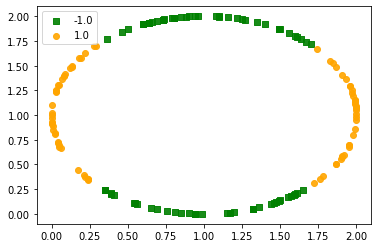

In [43]:
print("Plot points data after predict:")
output_dots, output_labels = point_arrays(points=dots, rules=lines)
plot_labels(X=output_dots, predicted_labels=output_labels)

In [7]:
print("Error")
i_train_error_graph = []
i_test_error_graph = []
for c in range(iterations):
    i_train_error = np.mean(train_errors[:,c])
    i_train_error_graph.append(i_train_error)
    i_test_error = np.mean(test_errors[:,c])
    i_test_error_graph.append(i_test_error)
    print(f"k = {c + 1}",
          "train error: ", "%.3f" % i_train_error,
          "| test error: ", "%.3f" % i_test_error)

Error
k = 1 train error:  0.220 | test error:  0.266
k = 2 train error:  0.268 | test error:  0.246
k = 3 train error:  0.000 | test error:  0.018
k = 4 train error:  0.008 | test error:  0.034
k = 5 train error:  0.000 | test error:  0.019
k = 6 train error:  0.000 | test error:  0.017
k = 7 train error:  0.000 | test error:  0.020
k = 8 train error:  0.000 | test error:  0.019


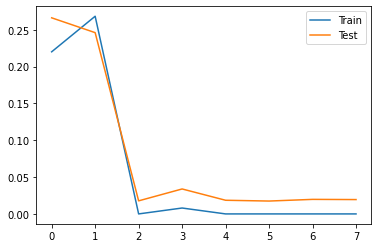

In [8]:
plt.plot(i_train_error_graph, label='Train')
plt.plot(i_test_error_graph, label="Test")
plt.legend()
plt.show()

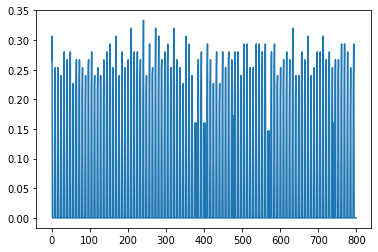

In [9]:
plt.plot(train_errors.flatten())
plt.show()

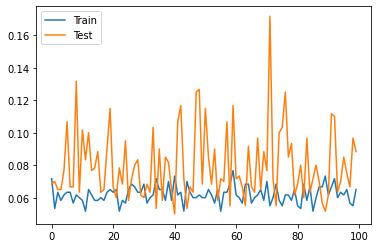

In [10]:
plt.plot(error_means_train, label='Train')
plt.plot(error_means_test, label='Test')
plt.legend(loc="upper left")
plt.show()

In [55]:
def most_important(lines):
    """
    Return most importent lines
    """
    last_index = 0
    min_l = lines[last_index]
    result = []
    for _ in range(iterations):
        min_lw = np.inf
        for i in range(len(lines)):
            if lines[i].w < min_lw:
                min_l = lines[i]
                min_lw = lines[i].w
                last_index = i
        result.append(min_l)
        np.delete(lines, last_index)
    return result

In [56]:
most_important_lines = most_important(lines=lines)

In [57]:
for most_line in most_important_lines:
    print(most_line.p1.x, most_line.p1.y)
    print(most_line.p2.x, most_line.p2.y)

0.56 1.9
0.01 0.9
0.56 1.9
0.01 0.9
0.56 1.9
0.01 0.9
0.56 1.9
0.01 0.9
0.56 1.9
0.01 0.9
0.56 1.9
0.01 0.9
0.56 1.9
0.01 0.9
0.56 1.9
0.01 0.9
